<a href="https://colab.research.google.com/github/paritachavda/Digit_recognition_using_CNN/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape


(60000, 28, 28)

In [0]:
import numpy as np
seed = 7
np.random.seed(seed)


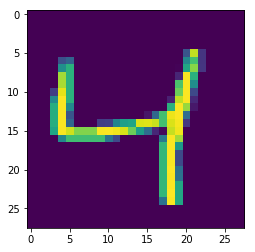

In [0]:
import matplotlib.pyplot as plt
#plot the first image in the dataset
plt.imshow(X_train[2])

In [0]:

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

In [0]:
X_train = X_train / 255
X_test = X_test / 255

In [0]:

from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
y_test.shape

(10000, 10)

In [0]:
class Convolution2D:

    def __init__(self, inputs_channel, num_filters, kernel_size, padding, stride, learning_rate, name):
        # weight size: (F, C, K, K)
        # bias size: (F) 
        self.F = num_filters
      
        self.K = kernel_size
        self.C = inputs_channel

        self.weights = np.zeros((self.F, self.C, self.K, self.K))
        self.bias = np.zeros((self.F, 1))
        for i in range(0,self.F):
            #loc = mean scale = std dev size = no. of samples of distibution
            self.weights[i,:,:,:] = np.random.normal(loc=0, scale=np.sqrt(1./(self.C*self.K*self.K)), size=(self.C, self.K, self.K))

        self.p = padding
        self.s = stride
        self.lr = learning_rate
        self.name = name

    def zero_padding(self, inputs, size):
        w, h = inputs.shape[0], inputs.shape[1]
        new_w = 2 * size + w
        new_h = 2 * size + h
        out = np.zeros((new_w, new_h))
        out[size:w+size, size:h+size] = inputs
        return out

    def forward(self, inputs):
        C = inputs.shape[0]
        W = inputs.shape[1]+2*self.p
        H = inputs.shape[2]+2*self.p
        self.inputs = np.zeros((C, W, H))
        for c in range(inputs.shape[0]):
            self.inputs[c,:,:] = self.zero_padding(inputs[c,:,:], self.p)
        WW = (W - self.K)/self.s + 1
        HH = (H - self.K)/self.s + 1
        feature_maps = np.zeros((self.F, int(WW), int(HH)))

        for f in range(self.F):
            for w in range(int(WW)):
                for h in range(int(HH)):
                    feature_maps[f,w,h]=np.sum(self.inputs[:,w:w+self.K,h:h+self.K]*self.weights[f,:,:,:])+self.bias[f]
        return feature_maps

    def backward(self, dy):

        C, W, H = self.inputs.shape
        dx = np.zeros(self.inputs.shape)
        dw = np.zeros(self.weights.shape)
        db = np.zeros(self.bias.shape)

        F, W, H = dy.shape
        for f in range(F):
            for w in range(W):
                for h in range(H):
                    dw[f,:,:,:]+=dy[f,w,h]*self.inputs[:,w:w+self.K,h:h+self.K]
                    dx[:,w:w+self.K,h:h+self.K]+=dy[f,w,h]*self.weights[f,:,:,:]

        for f in range(F):
            db[f] = np.sum(dy[f, :, :])

        self.weights -= self.lr * dw
        self.bias -= self.lr * db
        return dx

    def extract(self):
        return {self.name+'.weights':self.weights, self.name+'.bias':self.bias}

    def feed(self, weights, bias):
        self.weights = weights
        self.bias = bias
                                

class Maxpooling2D:

    def __init__(self, pool_size, stride, name):
        self.pool = pool_size
        self.s = stride
        self.name = name

    def forward(self, inputs):
        self.inputs = inputs
        C, W, H = inputs.shape
        new_width = (W - self.pool)/self.s + 1
        new_height = (H - self.pool)/self.s + 1
        out = np.zeros((int(C), int(new_width),int(new_height)),dtype=int)
        for c in range(int(C)):
            for w in range(int(W/self.s)):
                for h in range(int(H/self.s)):
                    out[c, w, h] = np.max(self.inputs[c, w*self.s:w*self.s+self.pool, h*self.s:h*self.s+self.pool])
        return out

    def backward(self, dy):
        C, W, H = self.inputs.shape
        dx = np.zeros(self.inputs.shape)
        
        for c in range(C):
            for w in range(0, W, self.pool):
                for h in range(0, H, self.pool):
                    st = np.argmax(self.inputs[c,w:w+self.pool,h:h+self.pool])
                    (idx, idy) = np.unravel_index(st, (self.pool, self.pool))
                    dx[c, int(w+idx), int(h+idy)] = dy[c, int(w/self.pool), int(h/self.pool)]
        return dx

    def extract(self):
        return 
    
class FullyConnected:

    def __init__(self, num_inputs, num_outputs, learning_rate, name):
        self.weights = 0.01*np.random.rand(num_inputs, num_outputs)
        self.bias = np.zeros((num_outputs, 1))
        self.lr = learning_rate
        self.name = name

    def forward(self, inputs):
        self.inputs = inputs
        return np.dot(self.inputs, self.weights) + self.bias.T

    def backward(self, dy):

        if dy.shape[0] == self.inputs.shape[0]:
            dy = dy.T
        dw = dy.dot(self.inputs)
        db = np.sum(dy, axis=1, keepdims=True)
        dx = np.dot(dy.T, self.weights.T)

        self.weights -= self.lr * dw.T
        self.bias -= self.lr * db

        return dx

    def extract(self):
        return {self.name+'.weights':self.weights, self.name+'.bias':self.bias}

    def feed(self, weights, bias):
        self.weights = weights
        self.bias = bias

class Flatten:
    def __init__(self):
        pass
    def forward(self, inputs):
        self.C, self.W, self.H = inputs.shape
        return inputs.reshape(1, self.C*self.W*self.H)
    def backward(self, dy):
        return dy.reshape(self.C, self.W, self.H)
    def extract(self):
        return

class ReLu:
    def __init__(self):
        pass
    def forward(self, inputs):
        self.inputs = inputs
        ret = inputs.copy()
        ret[ret < 0] = 0
        return ret
    def backward(self, dy):
        dx = dy.copy()
        dx[self.inputs < 0] = 0
        return dx
    def extract(self):
        return

class Softmax:
    def __init__(self):
        pass
    def forward(self, inputs):
        exp = np.exp(inputs, dtype=np.float)
        self.out = exp/np.sum(exp)
        return self.out
    def backward(self, dy):
        return self.out.T - dy.reshape(dy.shape[0],1)
    def extract(self):
        return

In [0]:

def cross_entropy(inputs, labels):

    out_num = labels.shape[0]
    
    p = np.sum(labels.reshape(1,out_num)*inputs)
    loss = -np.log(p)
    return loss

In [0]:
import sys
from time import *
class Net:
    def __init__(self):
        lr = 0.01
        self.layers = []
        self.layers.append(Convolution2D(inputs_channel=1, num_filters=6, kernel_size=5, padding=2, stride=1, learning_rate=lr, name='conv1'))
        self.layers.append(ReLu())
        self.layers.append(Maxpooling2D(pool_size=2, stride=2, name='maxpool2'))
        self.layers.append(Convolution2D(inputs_channel=6, num_filters=16, kernel_size=5, padding=0, stride=1, learning_rate=lr, name='conv3'))
        self.layers.append(ReLu())
        self.layers.append(Maxpooling2D(pool_size=2, stride=2, name='maxpool4'))
        self.layers.append(Convolution2D(inputs_channel=16, num_filters=120, kernel_size=5, padding=0, stride=1, learning_rate=lr, name='conv5'))
        self.layers.append(ReLu())
        self.layers.append(Flatten())
        self.layers.append(FullyConnected(num_inputs=120, num_outputs=84, learning_rate=lr, name='fc6'))
        self.layers.append(ReLu())
        self.layers.append(FullyConnected(num_inputs=84, num_outputs=10, learning_rate=lr, name='fc7'))
        self.layers.append(Softmax())
        self.lay_num = len(self.layers)

    def train(self, training_data, training_label, batch_size, epoch, weights_file):
        total_acc = 0
        for e in range(epoch):
            for batch_index in range(0, training_data.shape[0], batch_size):
                # batch input
                if batch_index + batch_size < training_data.shape[0]:
                    data = training_data[batch_index:batch_index+batch_size]
                    label = training_label[batch_index:batch_index + batch_size]
                else:
                    data = training_data[batch_index:training_data.shape[0]]
                    label = training_label[batch_index:training_label.shape[0]]
                loss = 0
                acc = 0
                start_time = time()
                for b in range(batch_size):
                    x = data[b]
                    y = label[b]
                    # forward pass
                    for l in range(self.lay_num):
                        output = self.layers[l].forward(x)
                        x = output
                    loss += cross_entropy(output, y)
                    if np.argmax(output) == np.argmax(y):
                        acc += 1
                        total_acc += 1
                    # backward pass
                    dy = y
                    for l in range(self.lay_num-1, -1, -1):
                        dout = self.layers[l].backward(dy)
                        dy = dout
                # time
                end_time = time()
                batch_time = end_time-start_time
                remain_time = (training_data.shape[0]*epoch-batch_index-training_data.shape[0]*e)/batch_size*batch_time
                hrs = int(remain_time)/3600
                mins = int((remain_time/60-hrs*60))
                secs = int(remain_time-mins*60-hrs*3600)
                # result
                loss /= batch_size
                batch_acc = float(acc)/float(batch_size)
                training_acc = float(total_acc)/float((batch_index+batch_size)*(e+1))
                print('=== Epoch: {0:d}/{1:d} === Iter:{2:d} === Loss: {3:.2f} === BAcc: {4:.2f} === TAcc: {5:.2f} === Remain: {6:d} Hrs {7:d} Mins {8:d} Secs ==='.format(e,epoch,batch_index+batch_size,loss,batch_acc,training_acc,int(hrs),int(mins),int(secs)))
        # dump weights and bias
        obj = []
        for i in range(self.lay_num):
            cache = self.layers[i].extract()
            obj.append(cache)
        with open(weights_file, 'wb') as handle:
            pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)


    def test(self, data, label, test_size):
        toolbar_width = 40
        sys.stdout.write("[%s]" % (" " * (toolbar_width-1)))
        sys.stdout.flush()
        sys.stdout.write("\b" * (toolbar_width))
        step = float(test_size)/float(toolbar_width)
        st = 1
        total_acc = 0
        for i in range(test_size):
            if i == round(step):
                step += float(test_size)/float(toolbar_width)
                st += 1
                sys.stdout.write(".")
                sys.stdout.flush()
            x = data[i]
            y = label[i]
            for l in range(self.lay_num):
                output = self.layers[l].forward(x)
                x = output
            if np.argmax(output) == np.argmax(y):
                total_acc += 1
        sys.stdout.write("\n")
        print('=== Test Size:{0:d} === Test Acc:{1:.2f} ==='.format(test_size, float(total_acc)/float(test_size)))


    def test_with_pretrained_weights(self, data, label, test_size, weights_file):
        with open(weights_file, 'rb') as handle:
            b = pickle.load(handle,encoding='iso-8859-1')
        self.layers[0].feed(b[0]['conv1.weights'], b[0]['conv1.bias'])
        self.layers[3].feed(b[3]['conv3.weights'], b[3]['conv3.bias'])
        self.layers[6].feed(b[6]['conv5.weights'], b[6]['conv5.bias'])
        self.layers[9].feed(b[9]['fc6.weights'], b[9]['fc6.bias'])
        self.layers[11].feed(b[11]['fc7.weights'], b[11]['fc7.bias'])
        toolbar_width = 40
        sys.stdout.write("[%s]" % (" " * (toolbar_width-1)))
        sys.stdout.flush()
        sys.stdout.write("\b" * (toolbar_width))
        step = float(test_size)/float(toolbar_width)
        st = 1
        total_acc = 0
        for i in range(test_size):
            if i == round(step):
                step += float(test_size)/float(toolbar_width)
                st += 1
                sys.stdout.write(".")
                sys.stdout.flush()
            x = data[i]
            y = label[i]
            for l in range(self.lay_num):
                output = self.layers[l].forward(x)
                x = output
            if np.argmax(output) == np.argmax(y):
                total_acc += 1
        sys.stdout.write("\n")
        print('=== Test Size:{0:d} === Test Acc:{1:.2f} ==='.format(test_size, float(total_acc)/float(test_size)))
        
    def predict_with_pretrained_weights(self, inputs, weights_file):
        with open(weights_file, 'rb') as handle:
            b = pickle.load(handle,encoding='iso-8859-1')
        self.layers[0].feed(b[0]['conv1.weights'], b[0]['conv1.bias'])
        self.layers[3].feed(b[3]['conv3.weights'], b[3]['conv3.bias'])
        self.layers[6].feed(b[6]['conv5.weights'], b[6]['conv5.bias'])
        self.layers[9].feed(b[9]['fc6.weights'], b[9]['fc6.bias'])
        self.layers[11].feed(b[11]['fc7.weights'], b[11]['fc7.bias'])
        for l in range(self.lay_num):
            output = self.layers[l].forward(inputs)
            inputs = output
        digit = np.argmax(output)
        probability = output[0, digit]
        return digit, probability


In [0]:

print('Training Lenet......')
net.train(X_train, y_train, 256, 5, 'weights.pkl')

# net.test(testing_data, testing_labels, 100)
# net.test_with_pretrained_weights(X_test, y_test,100, 'pretrained_weights.pkl')

Training Lenet......
=== Epoch: 0/5 === Iter:256 === Loss: 2.30 === BAcc: 0.11 === TAcc: 0.11 === Remain: 17 Hrs 0 Mins 0 Secs ===
=== Epoch: 0/5 === Iter:512 === Loss: 2.30 === BAcc: 0.13 === TAcc: 0.12 === Remain: 17 Hrs 0 Mins 0 Secs ===
=== Epoch: 0/5 === Iter:768 === Loss: 2.31 === BAcc: 0.10 === TAcc: 0.12 === Remain: 17 Hrs 0 Mins 0 Secs ===
=== Epoch: 0/5 === Iter:1024 === Loss: 2.30 === BAcc: 0.12 === TAcc: 0.12 === Remain: 17 Hrs 0 Mins 0 Secs ===
=== Epoch: 0/5 === Iter:1280 === Loss: 2.30 === BAcc: 0.11 === TAcc: 0.12 === Remain: 17 Hrs 0 Mins 0 Secs ===
=== Epoch: 0/5 === Iter:1536 === Loss: 2.31 === BAcc: 0.12 === TAcc: 0.12 === Remain: 17 Hrs 0 Mins 0 Secs ===
=== Epoch: 0/5 === Iter:1792 === Loss: 2.30 === BAcc: 0.08 === TAcc: 0.11 === Remain: 17 Hrs 0 Mins 0 Secs ===
=== Epoch: 0/5 === Iter:2048 === Loss: 2.31 === BAcc: 0.07 === TAcc: 0.11 === Remain: 17 Hrs 0 Mins 0 Secs ===
=== Epoch: 0/5 === Iter:2304 === Loss: 2.30 === BAcc: 0.11 === TAcc: 0.11 === Remain: 17 Hrs 0

In [0]:
import pickle
net = Net()
print('Testing Lenet......')
net.test_with_pretrained_weights(X_test, y_test,10000, 'pretrained_weights.pkl')

Testing Lenet......
[                                       ].......................................
=== Test Size:10000 === Test Acc:0.50 ===
